# Importing the necessary packages & libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import ast
import validators
import string
import demoji
import pyLDAvis.sklearn
import re
import nltk

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from nltk import pos_tag

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load the dataset

In [2]:
df = pd.read_csv('./translated_dataframe.csv')

In [3]:
df.head()

id      conversation_id  \
0  1598103832080584704  1598103832080584704   
1  1598103601507102720  1598103597388279808   
2  1598103593634369536  1598103593634369536   
3  1598103115060084736  1598103115060084736   
4  1598102468243599361  1598102468243599360   

                                          created_at        date      time  \
0  2022-12-01 07:56:59 Malay Peninsula Standard Time  2022-12-01  07:56:59   
1  2022-12-01 07:56:04 Malay Peninsula Standard Time  2022-12-01  07:56:04   
2  2022-12-01 07:56:02 Malay Peninsula Standard Time  2022-12-01  07:56:02   
3  2022-12-01 07:54:08 Malay Peninsula Standard Time  2022-12-01  07:54:08   
4  2022-12-01 07:51:34 Malay Peninsula Standard Time  2022-12-01  07:51:34   

               user_id                                              tweet  \
0  1582818998324178944  Twitterのフォロワーを増やしたい。最低でも1万人。 #ChatGPT  https:/...   
1  1454189325432901640  Overall, using AI to create art can expand the...   
2            118166119  Este prompt fue creado con #ChatGPT el nuevo m...   
3            141730376  Just played around with OpenAI's new #ChatGPT ...   
4           4034337795  I asked #ChatGPT to write me a story about Sov...   

  language                                 hashtags reply_to  \
0       ja                              ['chatgpt']       []   
1       en                              ['chatgpt']       []   
2       es  ['chatgpt', 'martesdedatos', 'chatgpt']       []   
3       en  ['chatgpt', 'embodiedcarbon', 'poetry']       []   
4       en                              ['chatgpt']       []   

                                     translated_text  \
0  I want to increase my Twitter followers. At le...   
1  Overall, using AI to create art can expand the...   
2  This prompt was created with #ChatGPT the new ...   
3  Just played around with OpenAI's new #ChatGPT ...   
4  I asked #ChatGPT to write me a story about Sov...   

                                      tokenized_text  
0  ['I', 'want', 'to', 'increase', 'my', 'Twitter...  
1  ['Overall', ',', 'using', 'AI', 'to', 'create'...  
2  ['This', 'prompt', 'was', 'created', 'with', '...  
3  ['Just', 'played', 'around', 'with', "OpenAI's...  
4  ['I', 'asked', '#ChatGPT', 'to', 'write', 'me'...

# Converting the dataframe to Documents

In [4]:
def DFToDocument(df):
    document = []
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    for i, row in df.iterrows():
        sentence = ""
        tokenized_text = ast.literal_eval(row['tokenized_text'])
        pos_tags = pos_tag(tokenized_text)
        tonkenized_text = [token for token, pos in pos_tags if pos not in ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'VB']]
        for token in tokenized_text:
            if token not in stop_words and not validators.url(token) and token not in string.punctuation and not re.search(r'(chat[-\s])?gpt|\d+', token.lower()):
                sentence += lemmatizer.lemmatize(token) + ' '
        sentence = demoji.replace(string = sentence, repl = "")
        document.append(sentence[:-1])
    return document

In [5]:
document = DFToDocument(df)

# Split the data into training and testing data
70% Training Data <br><br>
30% Testing Data

In [6]:
chatgpt_train, chatgpt_test = train_test_split(document, test_size=0.3, random_state=1)

# Utilizing Gensim & preprocess2.py file 

In [7]:
import preprocess2

chatgpt_docs_train = []

for sentence in chatgpt_train:
    tokenized_sentence = nltk.word_tokenize(sentence)
    chatgpt_docs_train.append(tokenized_sentence)

chatgpt_docs_test = []

for sentence in chatgpt_test:
    tokenized_sentence = nltk.word_tokenize(sentence)
    chatgpt_docs_test.append(tokenized_sentence)


In [8]:
import gensim
import preprocess2

chatgpt_dictionary_train = gensim.corpora.Dictionary(chatgpt_docs_train)
chatgpt_dictionary_test = gensim.corpora.Dictionary(chatgpt_docs_test)

chatgpt_vecs_train = preprocess2.docs2vecs(chatgpt_docs_train, chatgpt_dictionary_train)
chatgpt_vecs_test = preprocess2.docs2vecs(chatgpt_docs_test, chatgpt_dictionary_test)


# Fitting the training data into the LDA model

In [9]:
chatgpt_lda = gensim.models.ldamodel.LdaModel(
                                        corpus=chatgpt_vecs_train, 
                                        id2word=chatgpt_dictionary_train, 
                                        num_topics=6,
                                        alpha=0.9,
                                        eta=0.9)

In [10]:
topics = chatgpt_lda.show_topics(6, 5)

for i in range(0, 6):
    print(topics[i])

(0, '0.010*"#" + 0.006*"How" + 0.006*"The" + 0.004*"via" + 0.003*"AI"')
(1, '0.004*"What" + 0.003*"money" + 0.003*"#" + 0.003*"saying" + 0.002*"could"')
(2, '0.014*"\'s" + 0.010*"’" + 0.007*"AI" + 0.004*"chat" + 0.004*"use"')
(3, '0.007*"”" + 0.007*"“" + 0.005*"’" + 0.004*"…" + 0.003*"#"')
(4, '0.053*"I" + 0.009*"It" + 0.009*"..." + 0.008*"like" + 0.008*"AI"')
(5, '0.220*"#" + 0.028*"AI" + 0.007*"ai" + 0.005*"OpenAI" + 0.004*"technology"')


In [11]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [12]:
# Generate the visuals
visual= gensimvis.prepare(chatgpt_lda, chatgpt_vecs_train, chatgpt_dictionary_train)

/home/jupyter/.local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [13]:
# Save the output to the html file
pyLDAvis.save_html(visual, "topic_viz_gensim_v2_AE_09.html")

# Evaluating the Perplexity for the LDA Model

In [14]:
# Compute Perplexity
perplex= chatgpt_lda.log_perplexity(chatgpt_vecs_test, total_docs=None) 

In [15]:
print('\nPerplexity for LDAModel: ', perplex)


Perplexity for LDAModel:  -11.136641455668297


# Evaluating the Coherence for the LDA Model

In [16]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=chatgpt_lda, 
                                     texts=chatgpt_docs_test, 
                                     dictionary=chatgpt_dictionary_test, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score LDAModel: ', coherence_lda)


Coherence Score LDAModel:  0.6103451469542366


In [17]:
# Can take a long time to run. In this case we are going to  k_max=10.
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

model_list = []
coherence_values = []
model_topics = []

for num_topics in range(2, 10, 2):
    chatgpt_lda_x = gensim.models.ldamodel.LdaModel(corpus=chatgpt_vecs_train, id2word=chatgpt_dictionary_train, num_topics=num_topics)
    coherencemodel = CoherenceModel(model=chatgpt_lda_x, texts=chatgpt_docs_test, dictionary=chatgpt_dictionary_test, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(chatgpt_lda_x)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

print(datetime.datetime.now())

2023-04-11 13:28:40.261505
#Topics: 2 Score: 0.5675773049016657
#Topics: 4 Score: 0.6101588432660839
#Topics: 6 Score: 0.6363915791945993
#Topics: 8 Score: 0.6226761252307433
2023-04-11 13:28:54.601120


### Ploting the results of the Coherence Score (Y-axis) against the Number of Topics (X-Axis)

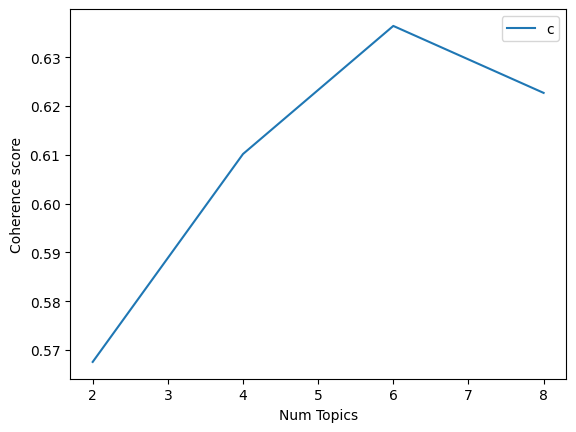

In [18]:
# Show graph

import matplotlib.pyplot as plt

limit=10; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Insights: The graph is aligned with our clustering results

In [19]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5676
Num Topics = 4  has Coherence Value of 0.6102
Num Topics = 6  has Coherence Value of 0.6364
Num Topics = 8  has Coherence Value of 0.6227


# Finding the most dominant topic among the dataset

In [20]:
#Find most dominant topic

import numpy as np
import pandas as pd

def format_topics_sentences(ldamodel, corpus, data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(data)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

#I choose model_list[2] where the number of topics is 6

df_topic_sents_keywords = format_topics_sentences(ldamodel=model_list[2], corpus=chatgpt_vecs_train, data=chatgpt_docs_train)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Percentage_Contribution', 'Keywords', 'Text']

# Show
pd.set_option("display.max_colwidth", None)
df_dominant_topic.head(6)

/tmp/ipykernel_85387/3348815634.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/tmp/ipykernel_85387/3348815634.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/tmp/ipykernel_85387/3348815634.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/tmp/ipykernel_85387/3348815634.py:18: FutureWarning: The frame.append method is deprecated and will be re

Document_No  Dominant_Topic  Topic_Percentage_Contribution  \
0            0               4                         0.7375   
1            1               2                         0.8620   
2            2               0                         0.1667   
3            3               2                         0.4749   
4            4               2                         0.5904   
5            5               2                         0.3273   

                                                                        Keywords  \
0  #, AI, ai, OpenAI, ArtificialIntelligence, openai, The, technology, What, via   
1                                I, 's, It, ..., asked, use, like, AI, think, 'm   
2         language, reply, model, natural, 's, man, Elon, Musk, artificial, half   
3                                I, 's, It, ..., asked, use, like, AI, think, 'm   
4                                I, 's, It, ..., asked, use, like, AI, think, 'm   
5                                I, 's, It, ..., asked, use, like, AI, think, 'm   

                                                                                                                                                                                                                                               Text  
0                                                                                                                                                                                                                               [More, #, ExoSquad]  
1  [I, 'm, exploring, using, get, way, help, #, teaching, lot, task, asked, #, faculty, day, take, needed, necessary, time, teaching, researching, appropriaterelevant, meaningful, tech, ARMtech, help, effectivity, quality, might, I, use, tech]  
2                                                                                                                                                                                                                                                []  
3                                                                   [Good, morning, When, I, woke, morning, open, PLUS, member, Today, World, Expo, Day, day, think, future, No, evolve, dramatically, ️, What, Expo, Day, #, トレンドキーワード解説, #, 万博デー]  
4                                                                                                                                                                                                                                      [using, igl]  
5                                           [Could, n't, agree, building, new, approach, break, browsing, unproductive, habit, exciting, thing, Me, team, working, web, extension, plugging, website, facilitating, effective, prompt, engineering]

# Saving the models

In [21]:
#Save a model to disk, or reload a pre-trained model
chatgpt_lda_sav = model_list[2] #Or you can save the best model, model_list[1]

chatgpt_lda_sav.save("LDAmodel_Topics_Gensim_V2_AE_09")

lda_disk = gensim.models.ldamodel.LdaModel.load("LDAmodel_Topics_Gensim_V2_AE_09")

In [22]:
#Code to save the document topic probabilities (theta)
import pandas as pd

vec = chatgpt_lda_sav[chatgpt_vecs_train]
pd.DataFrame(vec).to_csv("doc_topic_mixture_AE_09.csv")

In [23]:
# Write code here to save top 10 words for each topic (beta)
top_words_per_topic = []

for t in range(chatgpt_lda_sav.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in chatgpt_lda_sav.show_topic(t, topn = 10)])

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words_gensim_v2_AE_09.csv")

In [24]:
# END OF GENSIM V2 LDA